# Description

* Quality control on MiSeq run data
  * post-merging
  * post-demultiplexing

# Setting variables

In [1]:
import os

baseDir = '/home/seq_data/fullCyc2/amplicon/515F-806R/final_dataset/library_QC/Chantal_Pool9'
workDir = os.path.join(baseDir, 'QC')
seqFile = os.path.join(baseDir, 'pear_merged-Chantal_Pool9.assembled.dmult.fastq')

# number of processors
nprocs = 20

# max expected error
maxee = 1

# Init

In [2]:
import re
import pandas as pd

In [3]:
%load_ext rpy2.ipython
#%load_ext pushnote

In [4]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)

/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Want to understand how all the pieces fit together? Buy the ggplot2
book: http://ggplot2.org/book/

  warnings.warn(x, RRuntimeWarning)
/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  warnings.warn(x, RRuntimeWarning)
/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  warnings.warn(x, RRuntimeWarning)
/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘gridExtra’


  warnings.warn(x, RRuntimeWarn

In [5]:
if not os.path.isdir(workDir):
    os.makedirs(workDir)
%cd $workDir

/home/seq_data/fullCyc2/amplicon/515F-806R/final_dataset/library_QC/Chantal_Pool9/QC


In [6]:
# symlinking demult seq file into CQ
tmp = os.path.join(baseDir, seqFile)
if not os.path.isfile(seqFile):
    tmp2 = os.path.split(tmp)[1]
    os.symlink(tmp, tmp2)
else:
    print ('File exists: {}'.format(os.path.join(workDir, seqFile)))

File exists: /home/seq_data/fullCyc2/amplicon/515F-806R/final_dataset/library_QC/Chantal_Pool9/pear_merged-Chantal_Pool9.assembled.dmult.fastq


# Merged read quality filtering

## Discard sequences that exceed max expected error theshold

In [7]:
qcFile = os.path.split(seqFile)[1]
qcFile = os.path.splitext(qcFile)[0] + '_maxee{}.fasta'.format(maxee)
qcFile

'pear_merged-Chantal_Pool9.assembled.dmult_maxee1.fasta'

In [8]:
%%bash -s "$seqFile" "$nprocs" "$maxee" "$qcFile"

mkdir /home/sam/tmp/tmpdir1
trap "rm -r /home/sam/tmp/tmpdir1" 1 2 3 15
split -d -l 2000000 $1 /home/sam/tmp/tmpdir1/Block

mkdir /home/sam/tmp/tmpdir2
trap "rm -r /home/sam/tmp/tmpdir2" 1 2 3 15
ls /home/sam/tmp/tmpdir1/Block?? | parallel --gnu -j $2 -k "usearch -fastq_filter {} -fastq_maxee $3 \
-fastaout /home/sam/tmp/tmpdir2/{#}.fasta >/dev/null 2>&1 && cat /home/sam/tmp/tmpdir2/{#}.fasta" > $4
rm -r /home/sam/tmp/tmpdir2 /home/sam/tmp/tmpdir1

In [9]:
%%bash -s "$seqFile" "$nprocs" "$maxee" "$qcFile"

printf "Max expected error cutoff: "
echo $3

printf "Number of sequence pre-filter: "
grep -c "orig_name=" $1

printf "Number of sequences post-filter: "
grep -c ">" $4

echo '' 
head -n 8 $4

Max expected error cutoff: 1
Number of sequence pre-filter: 928383
Number of sequences post-filter: 924220

>BH.F.151026_0 orig_name=M02465:225:000000000-AKW2U:1:1101:15362:1338
TACGTAGGGGGCTAGCGTTGCTCGGAATCACTGGGCGTAAAGCGCACGTAGGCGGATCGTTAAGTCGGGGGTGAAATCCT
GGAGCTCAACACCAGAACTGCCTCCGATGCTGGCGATCGTGGAGTCCGGGAGAGGTGAGTGGAACTCCGAGTGTAGAGGT
GAAAGTCGTAGATATTCGGAAGAACACCAGTGGCGAAGGCGGCTCACTGGCCCGGTACTGACGCTGAGGTGCGATAGCGT
GGGGAGCAAACAGG
>EL.F.151026_1 orig_name=M02465:225:000000000-AKW2U:1:1101:15188:1341
TACGTAGGGGGCAAGCGTTGTCCGGAGTCATTGGGCGTAAAGAGCGTGCAGGCGGCCAGGTAGGTCTGCTGTGAAAACTC
GAGGCTCAACGTCGAGATGTCGGCGGAGACCGTCTGGCTAGAGTACGGAAGAGGAGAGTGGAATTCCCGGTGTAGCGGTG


## Remove seqs with 'N' characters

In [10]:
qcFile2 = os.path.splitext(qcFile)[0] + '_noN.fasta'
qcFile2

'pear_merged-Chantal_Pool9.assembled.dmult_maxee1_noN.fasta'

In [11]:
%%bash -s "$qcFile" "$qcFile2"

bioawk -c fastx '{if ($seq !~ /N/){print ">" $name " " $4 "\n" $seq}}' $1 > $2

printf "Number of sequence pre-filter: "
grep -c ">" $1

printf "Number of sequences post-filter: "
grep -c ">" $2

Number of sequence pre-filter: 924220
Number of sequences post-filter: 924220


## Alignment-based QC with Mothur

In [12]:
%%bash -s "$qcFile2"
# making mothur group file

perl -ne 'if(/^>/){ s/>(.+)(_\d+) .+/$1$2\t$1/; print;}' $1 > group_file.txt
head group_file.txt

BH.F.151026_0	BH.F.151026
EL.F.151026_1	EL.F.151026
CF.C.151027_3	CF.C.151027
MP.F.151026_2	MP.F.151026
EL.F.151026_4	EL.F.151026
PP.M.151026_5	PP.M.151026
BH.A.151026_8	BH.A.151026
BH.M.151026_7	BH.M.151026
BH.A.151026_11	BH.A.151026
PP.A.151026_6	PP.A.151026


In [13]:
! head -n 200 group_file.txt

BH.F.151026_0	BH.F.151026
EL.F.151026_1	EL.F.151026
CF.C.151027_3	CF.C.151027
MP.F.151026_2	MP.F.151026
EL.F.151026_4	EL.F.151026
PP.M.151026_5	PP.M.151026
BH.A.151026_8	BH.A.151026
BH.M.151026_7	BH.M.151026
BH.A.151026_11	BH.A.151026
PP.A.151026_6	PP.A.151026
EL.M.151026_12	EL.M.151026
CF.M.151027_10	CF.M.151027
SS.A.151026_16	SS.A.151026
BH.F.151026_18	BH.F.151026
CF.C.151027_17	CF.C.151027
CF.A.151027_19	CF.A.151027
SS.M.151026_9	SS.M.151026
EL.M.151026_13	EL.M.151026
BH.M.151026_24	BH.M.151026
BH.M.151026_23	BH.M.151026
MP.A.151026_22	MP.A.151026
CC.M.151027_14	CC.M.151027
MP.M.151026_28	MP.M.151026
SS.M.151026_31	SS.M.151026
MR.F.151027_25	MR.F.151027
MW.A.151027_27	MW.A.151027
BH.M.151026_34	BH.M.151026
MF.M.151026_29	MF.M.151026
CC.M.151027_32	CC.M.151027
EL.F.151026_36	EL.F.151026
MW.M.151027_37	MW.M.151027
MP.A.151026_30	MP.A.151026
MP.A.151026_38	MP.A.151026
BH.M.151026_39	BH.M.151026
PP.A.151026_15	PP.A.151026
BH.A.151026_40	BH.A.151026
BH.M.151026_42	BH.M.151026
BH.M.151026

In [14]:
# unique sequences
cmd = 'mothur "#unique.seqs(fasta={})"'.format(qcFile2)
!$cmd | tail -n 30

903000	598065
904000	598608
905000	599181
906000	599748
907000	600300
908000	600901
909000	601524
910000	602093
911000	602653
912000	603207
913000	603787
914000	604366
915000	604972
916000	605577
917000	606178
918000	606767
919000	607381
920000	607970
921000	608573
922000	609165
923000	609803
924000	610419
924220	610562

Output File Names: 
pear_merged-Chantal_Pool9.assembled.dmult_maxee1_noN.names
pear_merged-Chantal_Pool9.assembled.dmult_maxee1_noN.unique.fasta


mothur > quit()


In [15]:
qcFile3 = os.path.splitext(qcFile2)[0] + '.unique.fasta'
n_uniq = !grep -c ">" $qcFile3
print ('Number of unique sequences: {}'.format(n_uniq[0]))

Number of unique sequences: 610562


In [16]:
# name file produced by unique.seqs()
nameFile = os.path.splitext(qcFile2)[0] + '.names'
!ls -thlc $nameFile

-rw-rw-r-- 1 sam sam 28M May 14 21:46 pear_merged-Chantal_Pool9.assembled.dmult_maxee1_noN.names


In [17]:
%%bash 
# Remove database if already exsists
if [ -d mothur_silva_db ]; then
    rm -rf mothur_silva_db
fi

#if ! [ -d mothur_silva_db ]; then
#    mkdir mothur_silva_db
#fi

mkdir mothur_silva_db
cd mothur_silva_db

# Download mothur recreatd SEED database release 132.
wget https://www.mothur.org/w/images/7/71/Silva.seed_v132.tgz
#wget https://www.mothur.org/w/images/a/a4/Silva.seed_v128.tgz
tar -xvzf Silva.seed_v132.tgz
rm Silva.seed_v132.tgz

silva.seed_v132.tax
silva.seed_v132.align
README.md


--2018-05-14 21:46:34--  https://www.mothur.org/w/images/7/71/Silva.seed_v132.tgz
Resolving www.mothur.org (www.mothur.org)... 141.214.120.22
Connecting to www.mothur.org (www.mothur.org)|141.214.120.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19623900 (19M) [application/x-gzip]
Saving to: ‘Silva.seed_v132.tgz’

     0K .......... .......... .......... .......... ..........  0% 1.86M 10s
    50K .......... .......... .......... .......... ..........  0% 1006K 14s
   100K .......... .......... .......... .......... ..........  0% 1.88M 13s
   150K .......... .......... .......... .......... ..........  1%  991K 14s
   200K .......... .......... .......... .......... ..........  1% 1.89M 13s
   250K .......... .......... .......... .......... ..........  1%  992K 14s
   300K .......... .......... .......... .......... ..........  1% 1.89M 14s
   350K .......... .......... .......... .......... ..........  2%  395K 18s
   400K .......... .......... .......

In [18]:
silvaFile = 'silva.seed_v132.align'
cmd = 'mothur "#filter.seqs(vertical=t, fasta={}, processors={})"'.format(silvaFile, nprocs)
!cd mothur_silva_db; $cmd | tail -n 20

silvaFileFilt = os.path.splitext(silvaFile)[0] + '.filter.fasta'
silvaFileFilt = os.path.join('mothur_silva_db', silvaFileFilt)
ret = !grep -c ">" $silvaFileFilt
print ('\nNumber of sequences post-filter: {}'.format(ret[0]))

100
200
300
400
500
560



Length of filtered alignment: 10180
Number of columns removed: 39820
Length of the original alignment: 50000
Number of sequences used to construct filter: 11180

Output File Names: 
silva.filter
silva.seed_v132.filter.fasta


mothur > quit()

Number of sequences post-filter: 11180


In [19]:
# aligning sequences
qcFile3a = re.sub('-', '\-', qcFile3)
cmd = 'mothur "#align.seqs(candidate={}, template={}, processors=24, flip=T)"'.format(qcFile3a, silvaFileFilt)
!$cmd | tail -n 30

24700
24800
24900
25000
25100
25200
25300
25400
25500
25540
[WARNING]: Some of your sequences generated alignments that eliminated too many bases, a list is provided in pear_merged-Chantal_Pool9.assembled.dmult_maxee1_noN.unique.flip.accnos. If the reverse compliment proved to be better it was reported.
It took 212 secs to align 610562 sequences.


Output File Names: 
pear_merged-Chantal_Pool9.assembled.dmult_maxee1_noN.unique.align
pear_merged-Chantal_Pool9.assembled.dmult_maxee1_noN.unique.align.report
pear_merged-Chantal_Pool9.assembled.dmult_maxee1_noN.unique.flip.accnos


mothur > quit()


<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<^>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<^>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<^>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Detected 1 [WARNING] messages, please review.
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<^>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<^>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<^>>>>>>>>>>>>>>>>

In [20]:
qcFile4 = os.path.splitext(qcFile3)[0] + '.align'
!ls -thlc $qcFile4 

-rw-rw-r-- 1 sam sam 5.9G May 14 21:50 pear_merged-Chantal_Pool9.assembled.dmult_maxee1_noN.unique.align


In [21]:
# filtering out gap positions in the alignment
qcFile4a = re.sub('-', '\-', qcFile4)
cmd = 'mothur "#filter.seqs(vertical=t, fasta={}, processors={})"'.format(qcFile4a, nprocs)
!$cmd | tail -n 30

29100
29200
29300
29400
29500
29600
29700
29800
29900
30000
30100
30200
30300
30400
30500
30532



Length of filtered alignment: 1059
Number of columns removed: 9121
Length of the original alignment: 10180
Number of sequences used to construct filter: 610562

Output File Names: 
pear_merged-Chantal_Pool9.filter
pear_merged-Chantal_Pool9.assembled.dmult_maxee1_noN.unique.filter.fasta


mothur > quit()


In [22]:
qcFile5 = os.path.splitext(qcFile3)[0] + '.filter.fasta'
!ls -thlc $qcFile5

-rw-rw-r-- 1 sam sam 629M May 14 21:50 pear_merged-Chantal_Pool9.assembled.dmult_maxee1_noN.unique.filter.fasta


In [23]:
cmd = 'mothur "#summary.seqs(fasta={}, processors={}, name={})"'.format(qcFile5, nprocs, nameFile)
!$cmd | tail -n 20

Using 20 processors.

		Start	End	NBases	Ambigs	Polymer	NumSeqs
Minimum:	1	1	1	0	1	1
2.5%-tile:	123	806	253	0	4	23106
25%-tile:	123	806	253	0	4	231056
Median: 	123	806	253	0	5	462111
75%-tile:	123	806	253	0	5	693166
97.5%-tile:	123	806	254	0	8	901115
Maximum:	1059	1059	320	0	22	924220
Mean:	123.168	805.933	253.03	0	4.78086
# of unique seqs:	610562
total # of seqs:	924220

Output File Names: 
pear_merged-Chantal_Pool9.assembled.dmult_maxee1_noN.unique.filter.summary

It took 3 secs to summarize 924220 sequences.

mothur > quit()


## Removing homopolymers (> 8) and screening out sequences that don't align to an amplicon region

In [24]:
cmd = """mothur '#screen.seqs(fasta={},\
    processors={},\
    name={},\
    group={},\
    start={},\
    end={},\
    maxhomop=8)'""".format(qcFile5, nprocs, nameFile, 'group_file.txt', 123, 806)
!$cmd | tail -n 30

Processing sequence: 29700
Processing sequence: 29800
Processing sequence: 29900
Processing sequence: 30000
Processing sequence: 30100
Processing sequence: 30200
Processing sequence: 30300
Processing sequence: 30400
Processing sequence: 30500
Processing sequence: 30524
ssing sequence: 29800
Processing sequence: 29900
Processing sequence: 30000
Processing sequence: 30100
Processing sequence: 30200
Processing sequence: 30300
Processing sequence: 30400
Processing sequence: 30500
Processing sequence: 30562

Output File Names: 
pear_merged-Chantal_Pool9.assembled.dmult_maxee1_noN.unique.filter.good.fasta
pear_merged-Chantal_Pool9.assembled.dmult_maxee1_noN.unique.filter.bad.accnos
pear_merged-Chantal_Pool9.assembled.dmult_maxee1_noN.good.names
group_file.good.txt


It took 6 secs to screen 610562 sequences.

mothur > quit()


In [25]:
qcFile6 = os.path.splitext(qcFile5)[0] + '.good.fasta'
ret = !grep -c ">" $qcFile6
print ('Number of sequences post-filter: {}'.format(ret[0]))

Number of sequences post-filter: 599077


In [26]:
qcFile6a = re.sub('-', '\-', qcFile6)
cmd = 'mothur "#filter.seqs(fasta={}, processors={}, vertical=T)"'.format(qcFile6a, nprocs)
!$cmd | tail -n 20

29500
29600
29700
29800
29900
29987



Length of filtered alignment: 789
Number of columns removed: 270
Length of the original alignment: 1059
Number of sequences used to construct filter: 599077

Output File Names: 
pear_merged-Chantal_Pool9.filter
pear_merged-Chantal_Pool9.assembled.dmult_maxee1_noN.unique.filter.good.filter.fasta


mothur > quit()


In [27]:
qcFile7 = os.path.splitext(qcFile6)[0] + '.filter.fasta'
!ls -thlc $qcFile7

-rw-rw-r-- 1 sam sam 463M May 14 21:56 pear_merged-Chantal_Pool9.assembled.dmult_maxee1_noN.unique.filter.good.filter.fasta


## Deunique seqs

In [28]:
cmd = 'mothur "#deunique.seqs(fasta={}, name={})"'.format(qcFile7, nameFile)
!$cmd | tail -n 30

mothur v.1.39.5
Last updated: 3/20/2017

by
Patrick D. Schloss

Department of Microbiology & Immunology
University of Michigan
http://www.mothur.org

When using, please cite:
Schloss, P.D., et al., Introducing mothur: Open-source, platform-independent, community-supported software for describing and comparing microbial communities. Appl Environ Microbiol, 2009. 75(23):7537-41.

Distributed under the GNU General Public License

Type 'help()' for information on the commands that are available

For questions and analysis support, please visit our forum at https://www.mothur.org/forum

Type 'quit()' to exit program



mothur > deunique.seqs(fasta=pear_merged-Chantal_Pool9.assembled.dmult_maxee1_noN.unique.filter.good.filter.fasta, name=pear_merged-Chantal_Pool9.assembled.dmult_maxee1_noN.names)

Output File Names: 
pear_merged-Chantal_Pool9.assembled.dmult_maxee1_noN.unique.filter.good.filter.redundant.fasta


mothur > quit()


### Final QC-ed file

In [29]:
qcFile8 = os.path.splitext(qcFile7)[0] + '.redundant.fasta'
qcFinal = 'finalQC.fasta'
!perl -pe 's/[-.]//g if ! /^>/' $qcFile8 > $qcFinal

In [30]:
cmd = 'mothur "#summary.seqs(fasta={}, processors={})"'.format(qcFinal, nprocs)
!$cmd | tail -n 20


Using 20 processors.

		Start	End	NBases	Ambigs	Polymer	NumSeqs
Minimum:	1	213	213	0	3	1
2.5%-tile:	1	253	253	0	4	22694
25%-tile:	1	253	253	0	4	226939
Median: 	1	253	253	0	5	453878
75%-tile:	1	253	253	0	5	680817
97.5%-tile:	1	254	254	0	8	885062
Maximum:	1	320	320	0	8	907755
Mean:	1	253.098	253.098	0	4.76179
# of Seqs:	907755

Output File Names: 
finalQC.summary

It took 1 secs to summarize 907755 sequences.

mothur > quit()


In [31]:
!head -n 6 $qcFinal

>BH.F.151026_0
TACGTAGGGGGCTAGCGTTGCTCGGAATCACTGGGCGTAAAGCGCACGTAGGCGGATCGTTAAGTCGGGGGTGAAATCCTGGAGCTCAACACCAGAACTGCCTCCGATGCTGGCGATCGTGGAGTCCGGGAGAGGTGAGTGGAACTCCGAGTGTAGAGGTGAAAGTCGTAGATATTCGGAAGAACACCAGTGGCGAAGGCGGCTCACTGGCCCGGTACTGACGCTGAGGTGCGATAGCGTGGGGAGCAAACAGG
>EL.F.151026_1
TACGTAGGGGGCAAGCGTTGTCCGGAGTCATTGGGCGTAAAGAGCGTGCAGGCGGCCAGGTAGGTCTGCTGTGAAAACTCGAGGCTCAACGTCGAGATGTCGGCGGAGACCGTCTGGCTAGAGTACGGAAGAGGAGAGTGGAATTCCCGGTGTAGCGGTGAAATGCGCAGATATCAGGAGGGAGACCCGTGGCGAAGGCGGCTCTCTGGGACGGTACTGACGCTGAGACGCGATAGCGTGGGGAGCAAACAGG
>CF.C.151027_3
TACGGAAGGGGCAAGCGTTGTTCGGAATTATTGGGCGTAAAGGGCGCGTAGGTGGTTCTGTGTGTCTATCGTGAAAGGGTACAGCTCAACTGTAGAGAGTCGGTAGAAACTGCAGGACTTGAGGCTGGGAGGGGCTGGTGGAATTCCCTGTGTAGCGGTGAAATGCGTAGAGATCGGGAGGAAGGCCGGTGGCGAAGGCGGCGCTCTGGAACGTTTCTGACGCTGAGGCTCGAGAGCGTGGGGAGCAAACAGG


## Summary of number of seqs per sample

In [32]:
re1 = re.compile('_[0-9]+$')

qcFinalSum = os.path.splitext(qcFinal)[0] + '.summary'

samp_count = dict()
with open(qcFinalSum, 'r') as inFH:
    for line in inFH:
        if line.startswith('seqname'):
            continue
        line = line.rstrip().split('\t')
        line[0] = re.sub(re1, '', line[0])
        try:
            samp_count[line[0]] += 1
        except KeyError:
            samp_count[line[0]] = 1

In [33]:
# converting to dataframe
df_seq_cnt = pd.DataFrame.from_dict(samp_count, orient='index')
df_seq_cnt.index.name = 'Sample'
df_seq_cnt.reset_index(inplace=True)
df_seq_cnt.columns = ['Sample', 'seq_count']
df_seq_cnt

,Sample,seq_count
0,BH.F.151026,39253
1,EL.F.151026,36909
2,CF.C.151027,25927
3,MP.F.151026,31604
4,PP.M.151026,33802
5,BH.A.151026,29961
6,CC.A.151027,35506
7,CC.F.151027,26042
8,MP.M.151026,31069
9,MP.A.151026,36595


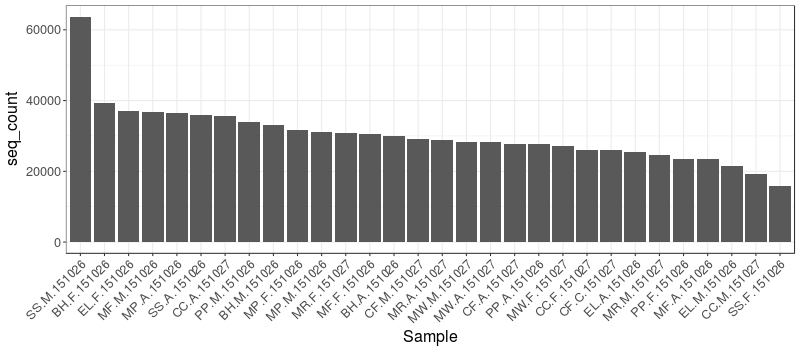

In [34]:
%%R -i df_seq_cnt -w 800 -h 350
# plotting all

df_seq_cnt$seq_count = as.numeric(df_seq_cnt$seq_count)


df_seq_cnt = df_seq_cnt %>% 
    #mutate(H2O = grepl('_F0$', Sample)) %>%
    mutate(rank = min_rank(seq_count)) %>%
    arrange(desc(rank))

df_seq_cnt$Sample = factor(df_seq_cnt$Sample, levels=df_seq_cnt$Sample)

ggplot(df_seq_cnt, aes(Sample, seq_count)) +
    geom_bar(stat='identity') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)
    )

In [1]:
%%R
df_seq_cnt[df_seq_cnt$seq_count < 10000,]

ERROR:root:Cell magic `%%R` not found.
